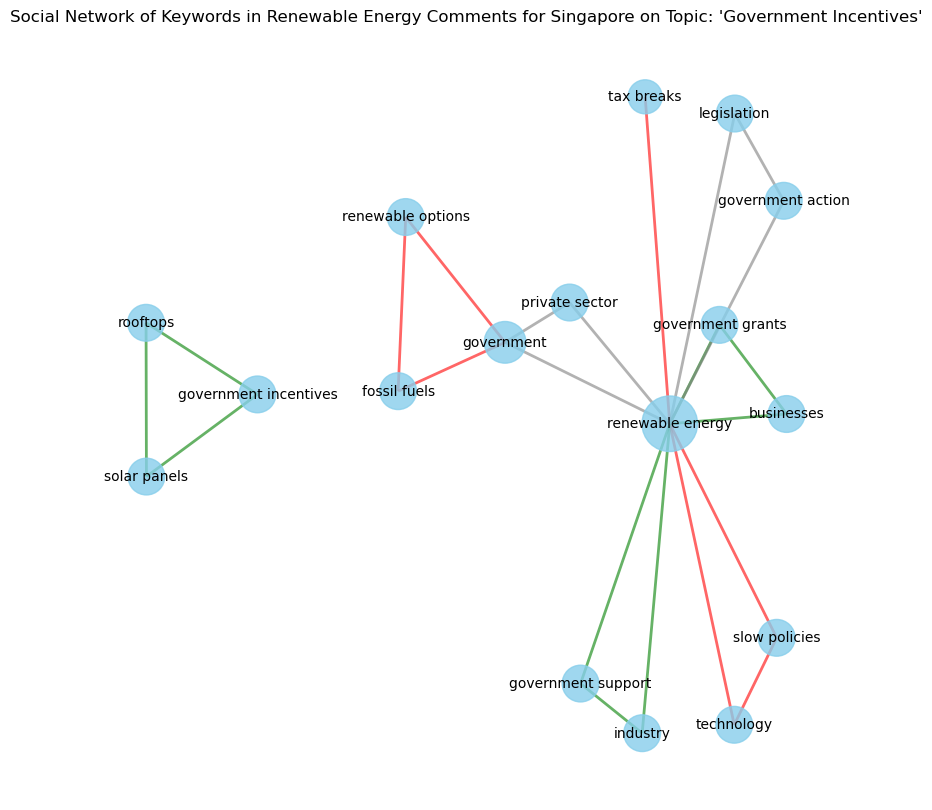

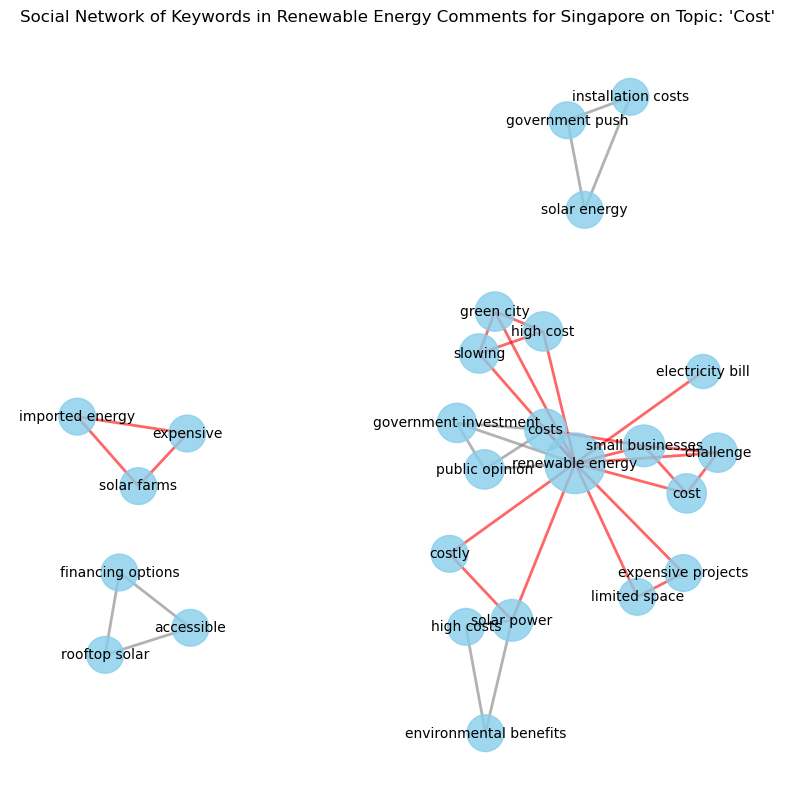

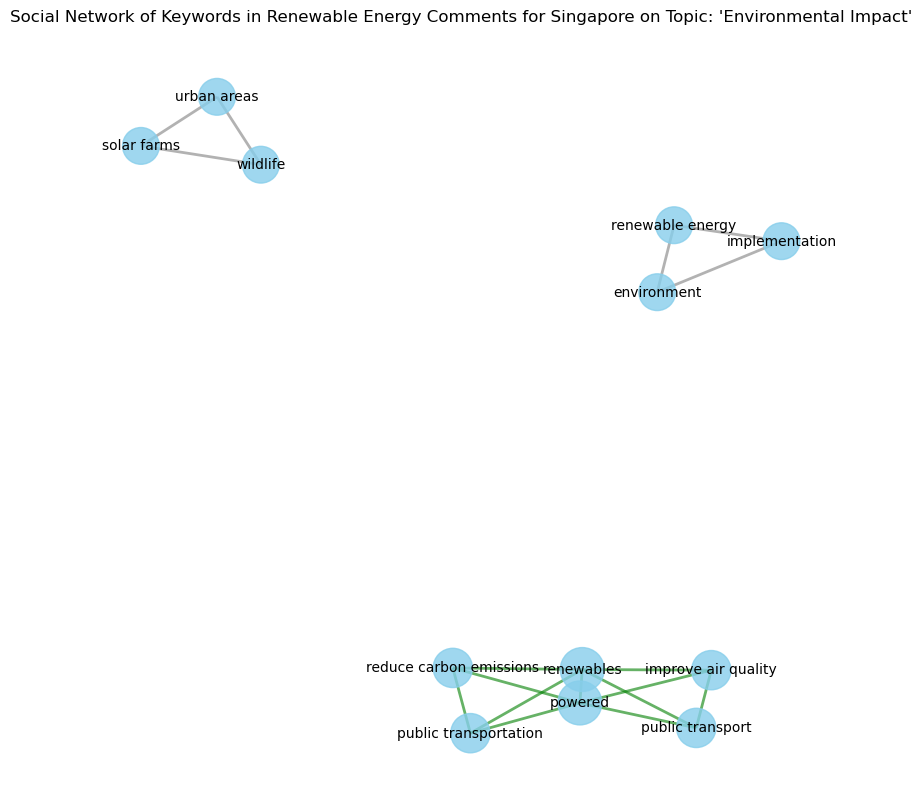

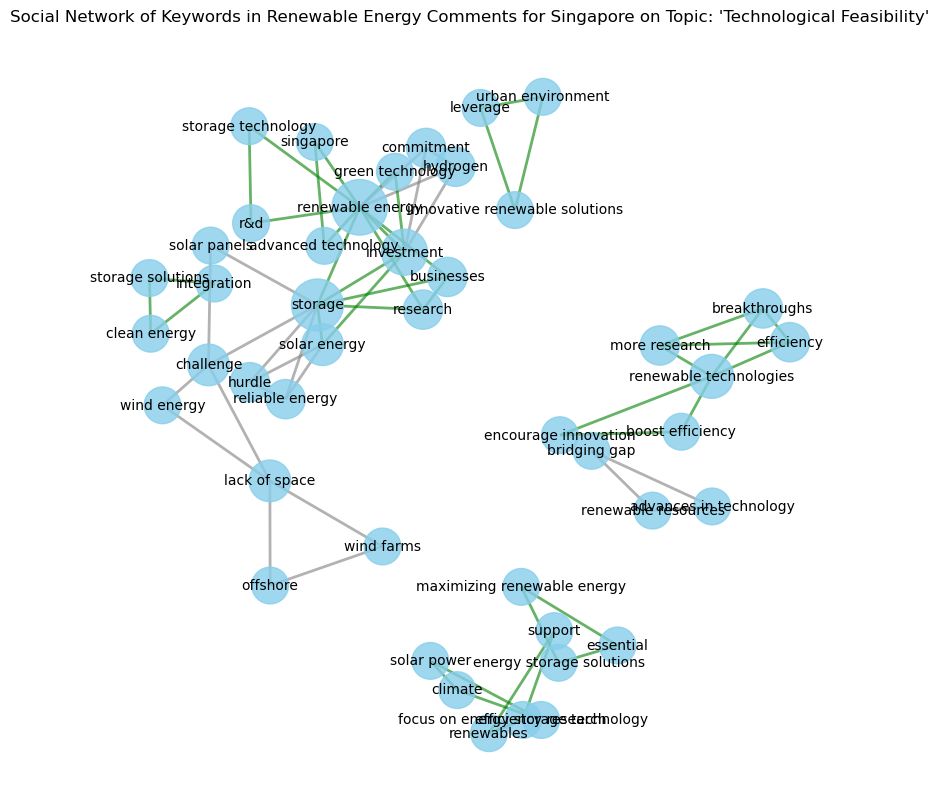

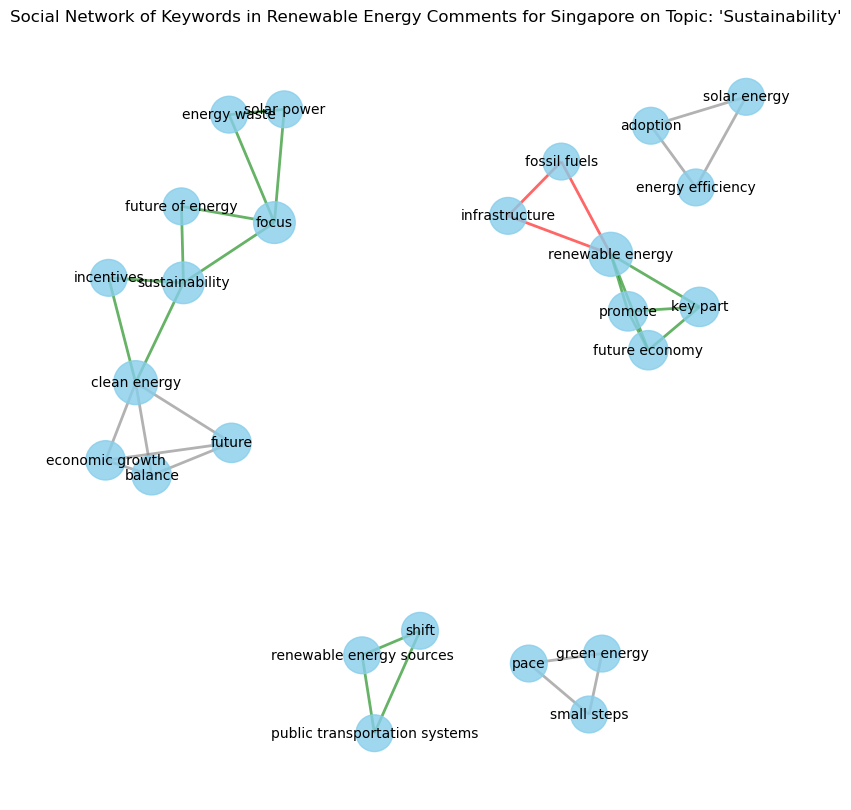

No data to display for Singapore on topic 'Economic Impact'.


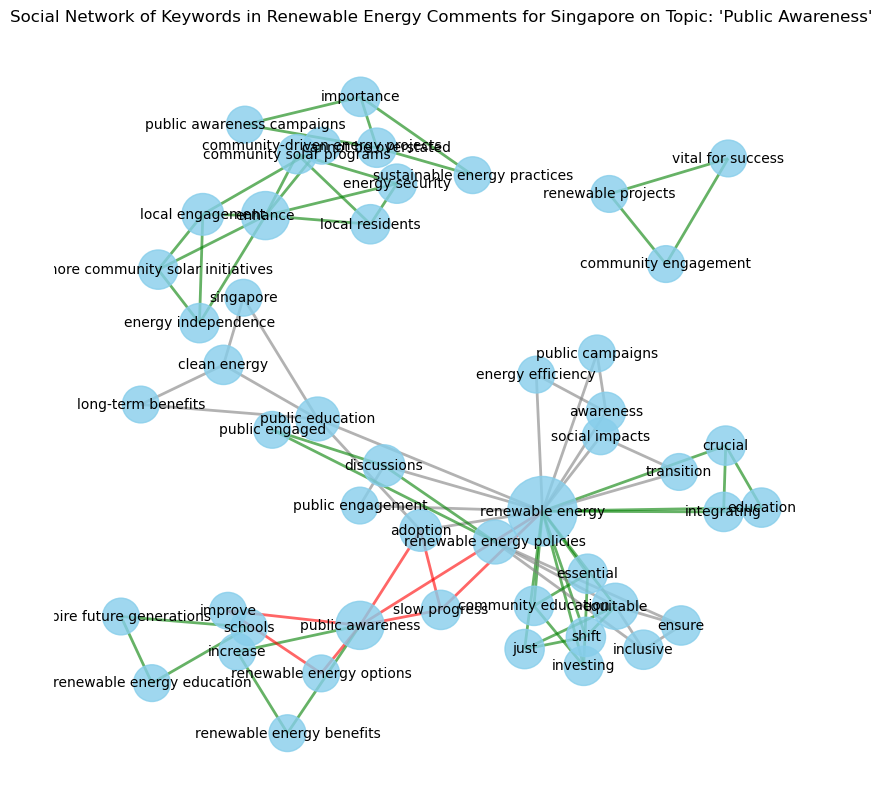

No data to display for Singapore on topic 'Global Comparison'.


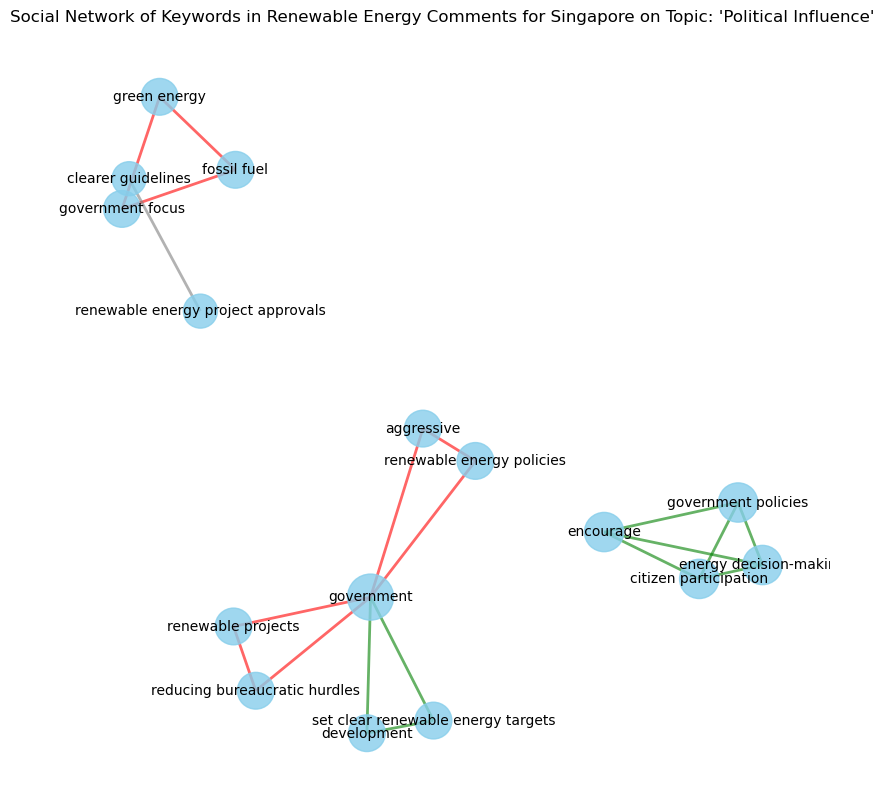

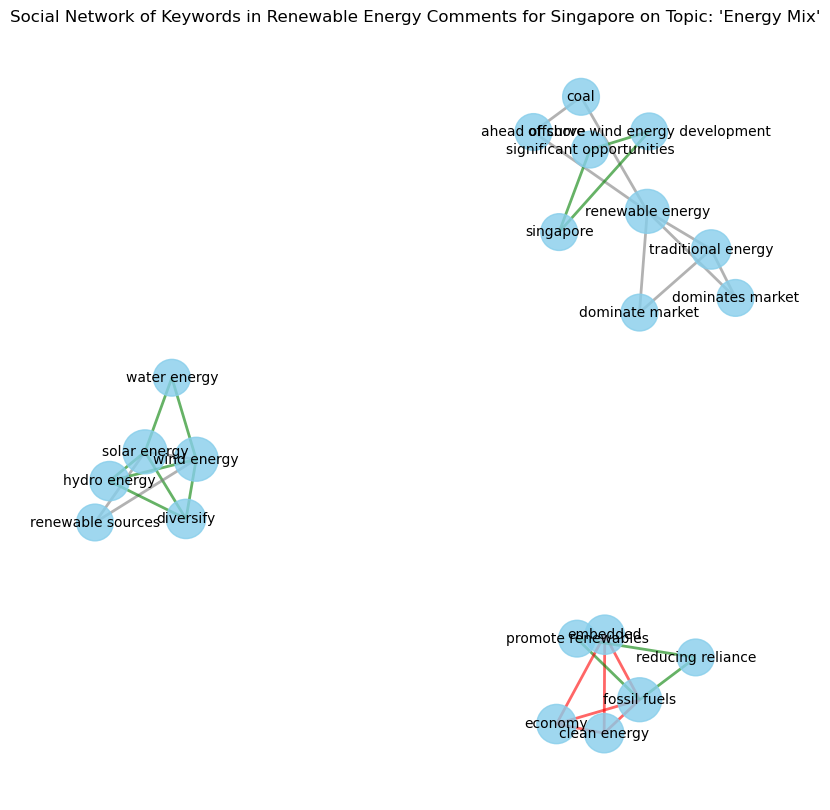

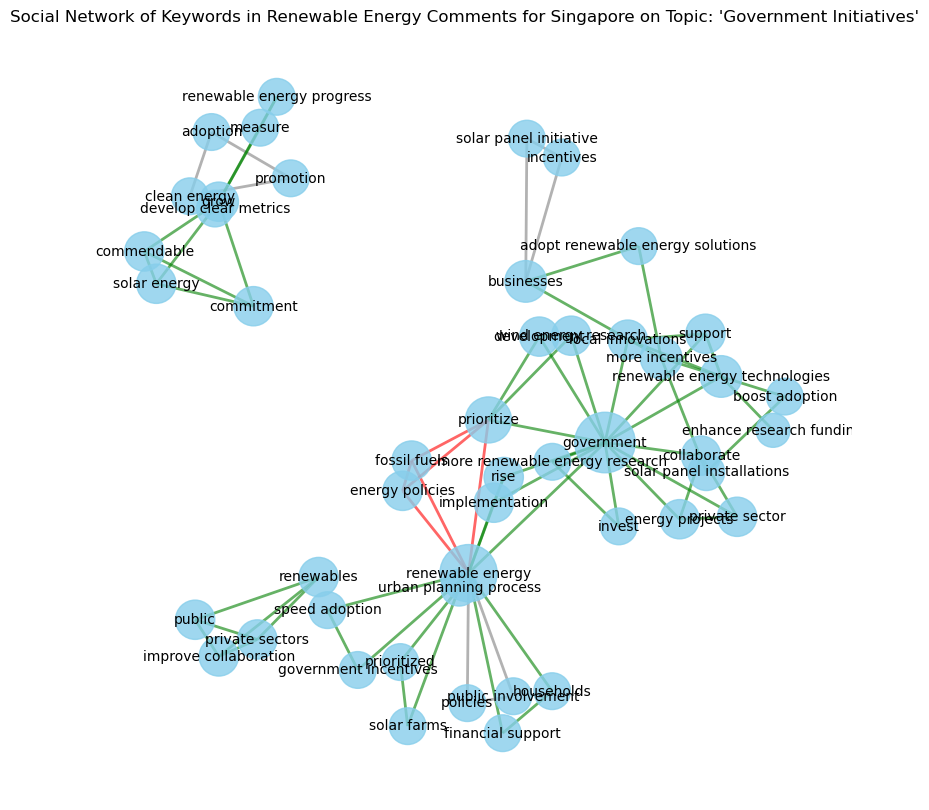

No data to display for Singapore on topic 'Global Leadership'.
No data to display for Singapore on topic 'Economic Growth vs. Sustainability'.


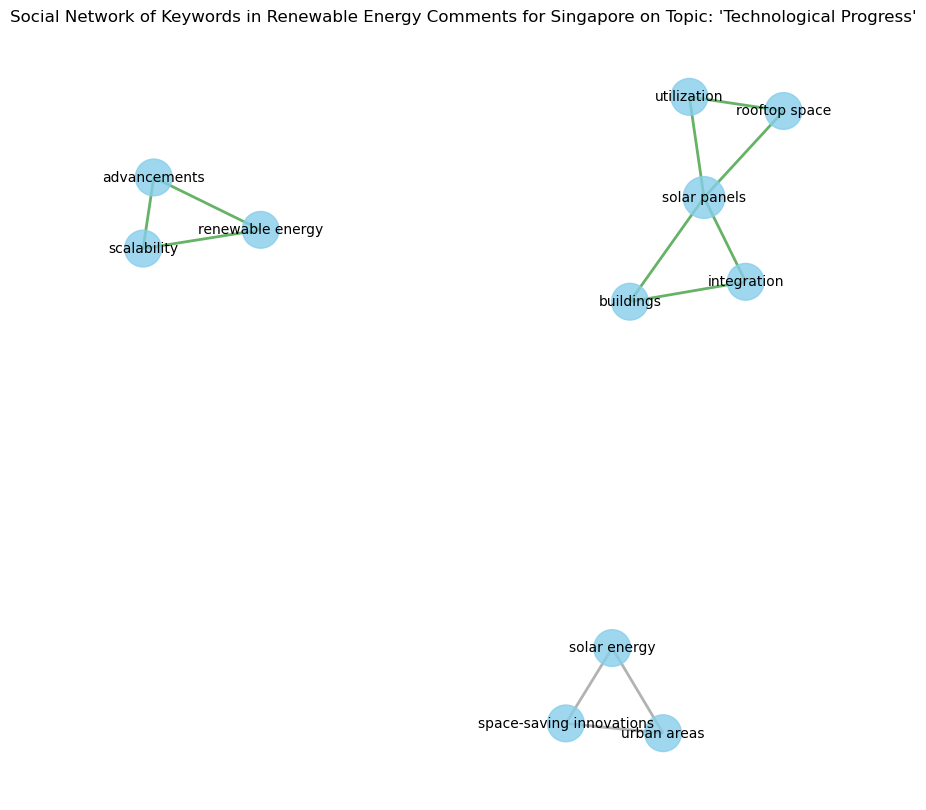

No data to display for Singapore on topic 'Public Health'.


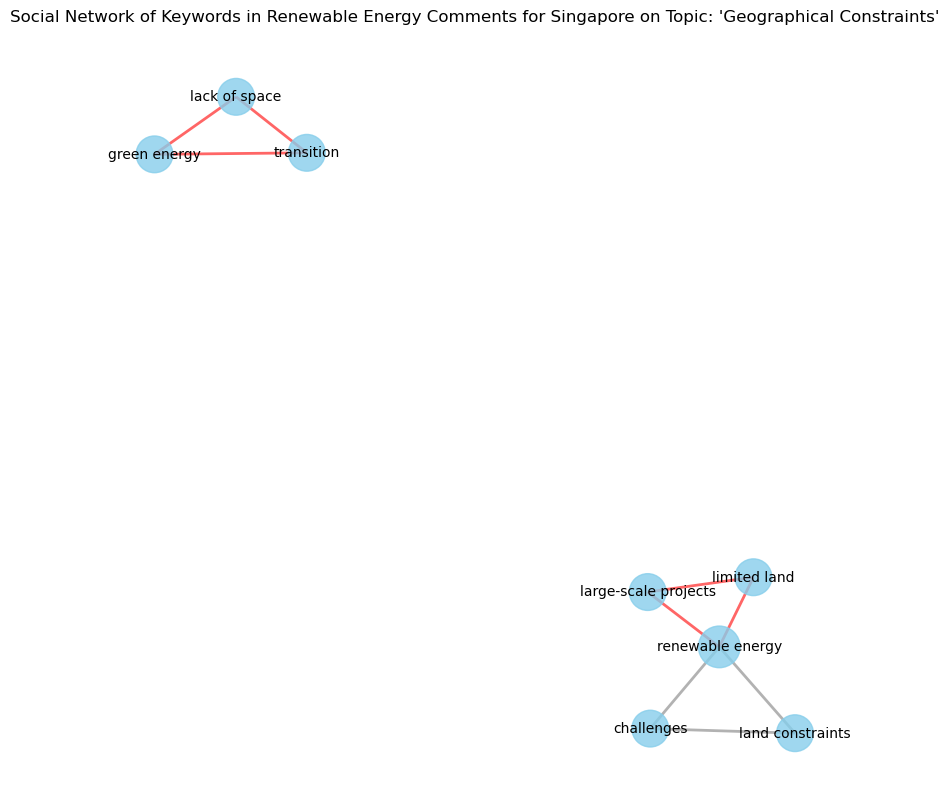

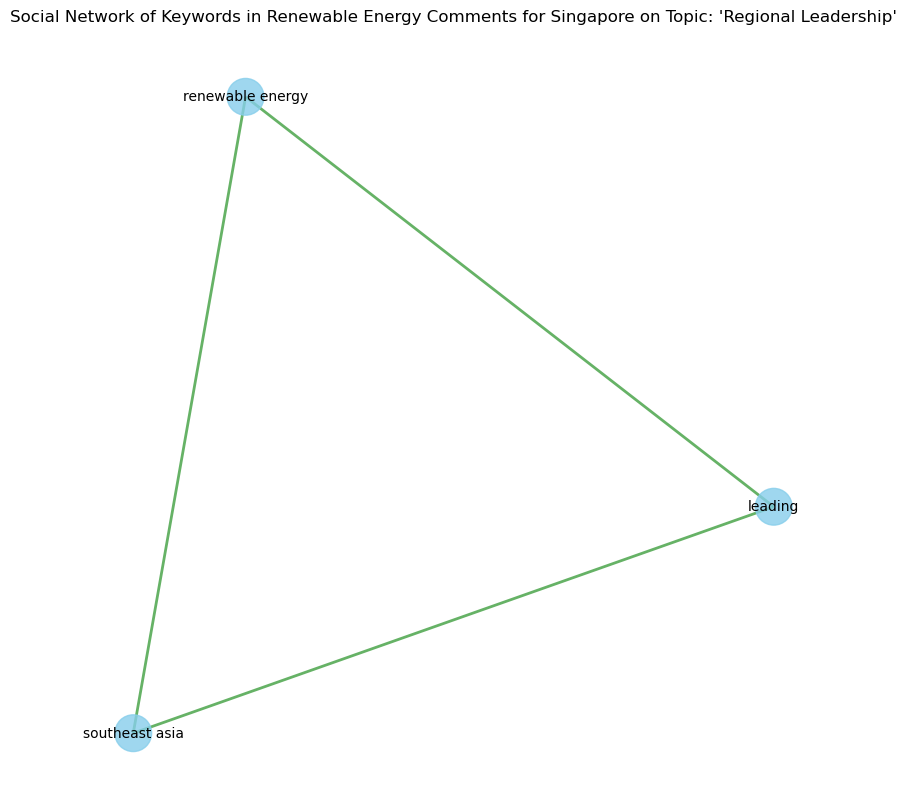

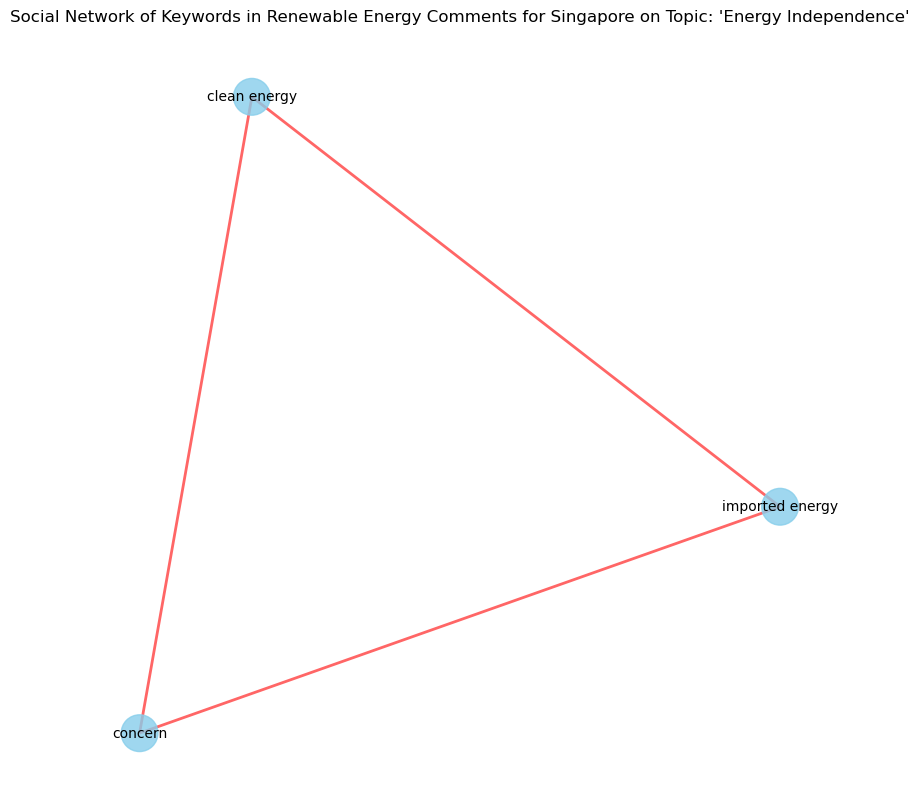

No data to display for Singapore on topic 'Regional Disparities'.


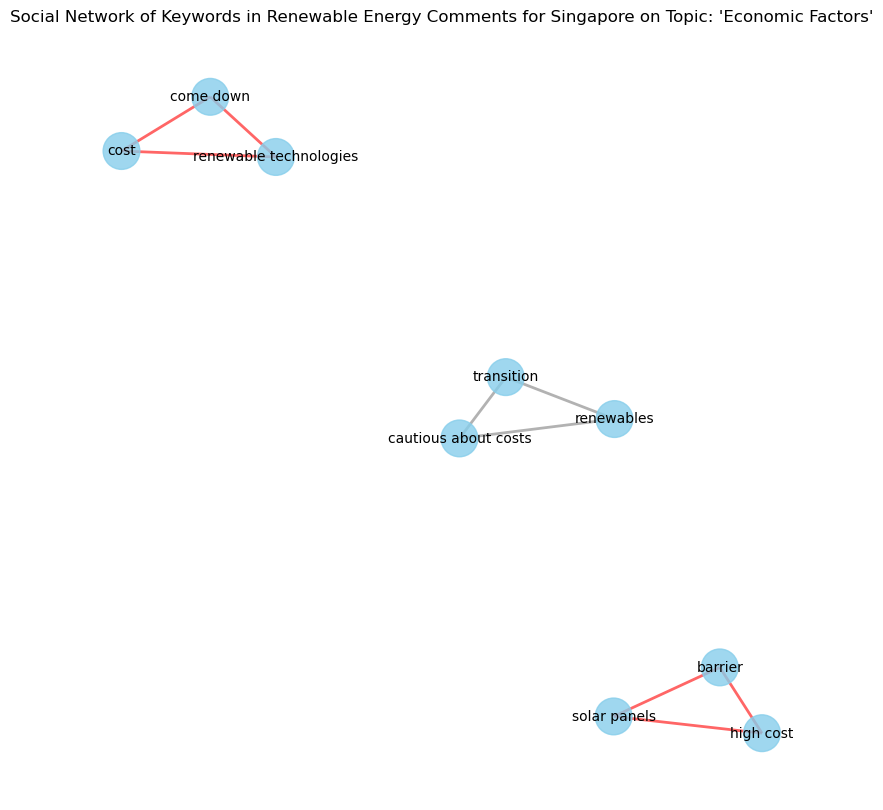

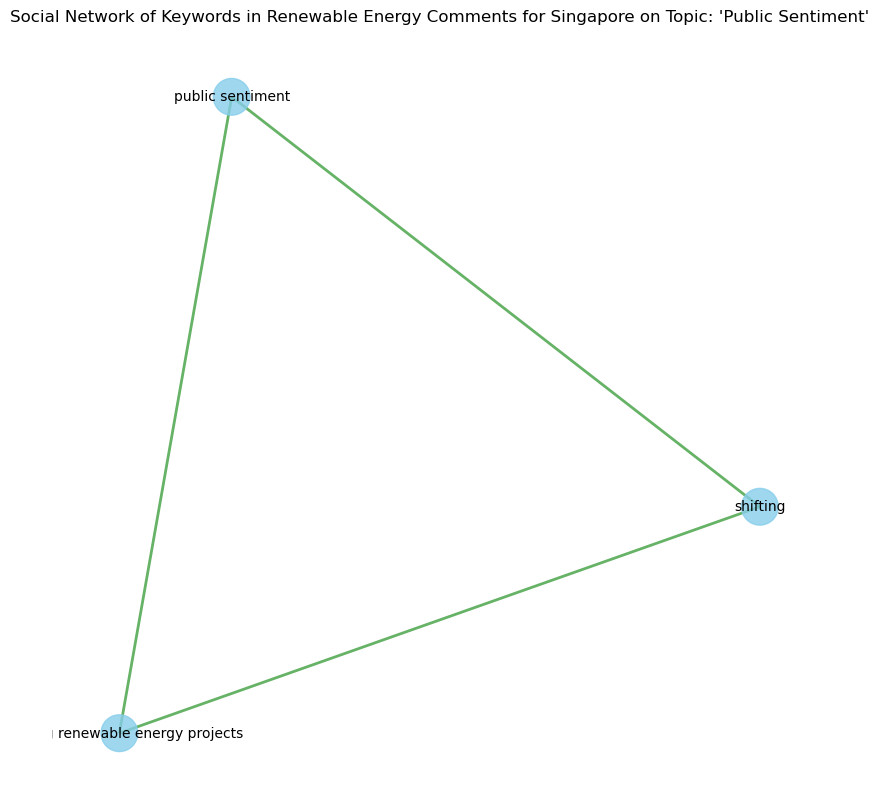

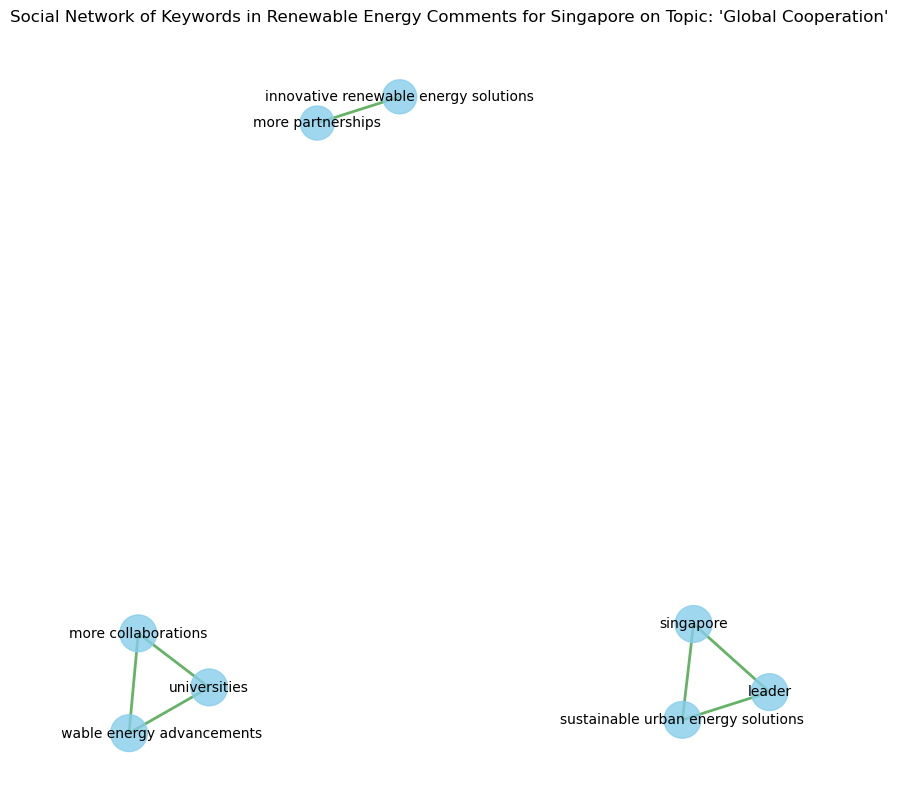

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# Load the dataset from Excel
file_path = 'Comment_topics.xlsx'  # Replace with your actual file path
df = pd.read_excel(file_path)

# Function to clean keywords
def clean_keywords(keyword_string):
    return [kw.strip().lower() for kw in keyword_string.split(',')]

# Apply keyword cleaning to the 'Keywords' column
df['Keywords'] = df['Keywords'].apply(clean_keywords)

# Function to create a social network graph with sentiment-based edges
def create_sentiment_network_graph(df, country, topic, weight_threshold=2, top_n_nodes=None):
    # Filter the DataFrame for the specified country and topic
    filtered_df = df[(df['Country'].str.lower() == country.lower()) & (df['Topic'] == topic)]

    # Initialize a network graph
    G = nx.Graph()

    # Add nodes and edges based on co-occurrence of keywords in each comment, with sentiment
    for _, row in filtered_df.iterrows():
        keywords = row['Keywords']
        sentiment = row['Sentiment'].lower()  # Get the sentiment of the comment

        # Create edges between all pairs of keywords within the same comment
        for kw1, kw2 in combinations(keywords, 2):
            if G.has_edge(kw1, kw2):
                G[kw1][kw2]['weight'] += 1  # Increment weight if the edge already exists
            else:
                # Initialize the edge with sentiment
                G.add_edge(kw1, kw2, weight=1, sentiment=sentiment)

    # Remove edges below the weight threshold
    G.remove_edges_from([(u, v) for u, v, d in G.edges(data=True) if d['weight'] < weight_threshold])

    # Optionally filter to keep only the top N most connected nodes
    if top_n_nodes:
        degrees = dict(G.degree())
        top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:top_n_nodes]
        G = G.subgraph(top_nodes).copy()

    # Remove isolated nodes
    G.remove_nodes_from(list(nx.isolates(G)))

    # Check if the graph has nodes before drawing
    if G.number_of_nodes() > 0:
        plt.figure(figsize=(10, 10))

        # Position nodes using the spring layout
        pos = nx.spring_layout(G, k=0.5, seed=42)

        # Get edge colors based on sentiment
        edge_colors = []
        for u, v, d in G.edges(data=True):
            if d['sentiment'] == 'positive':
                edge_colors.append('green')
            elif d['sentiment'] == 'negative':
                edge_colors.append('red')
            else:
                edge_colors.append('gray')  # Neutral sentiment

        # Draw nodes
        node_sizes = [500 + (len(list(G.neighbors(n))) * 100) for n in G.nodes()]
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue", alpha=0.8)

        # Draw edges with sentiment-based colors
        nx.draw_networkx_edges(G, pos, width=2, edge_color=edge_colors, alpha=0.6)

        # Add labels to nodes
        nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

        # Display the graph
        plt.title(f"Social Network of Keywords in Renewable Energy Comments for {country.capitalize()} on Topic: '{topic}'")
        plt.axis('off')
        plt.show()
    else:
        print(f"No data to display for {country.capitalize()} on topic '{topic}'.")

# Example usage: create separate graphs for each topic
country = 'Singapore'  # Specify the country
topics = df['Topic'].unique()  # Get unique topics

for topic in topics:
    create_sentiment_network_graph(df, country, topic, weight_threshold=0, top_n_nodes=2000)
